In [1]:
# %config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd
import rtree 
import fiona
import geopandas
import numpy as np
import shapely

In [3]:
import matplotlib.pyplot as plt

# Pre-processing data

We will use data from [Chicago, US](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2/data). It is already on this directory:

In [4]:
df = pd.read_csv("./chicago.zip")

In [5]:
df.head()

,Unnamed: 0,Unnamed: 0.1,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,2,2,11646166,JC213529,2018-09-01 00:01:00,082XX S INGLESIDE AVE,0810,THEFT,OVER $500,RESIDENCE,...,8.0,44.0,06,NaN,NaN,2018,04/06/2019 04:04:43 PM,NaN,NaN,NaN
1,89,90,12014684,JD189901,2020-03-17 21:30:00,039XX N LECLAIRE AVE,0820,THEFT,$500 AND UNDER,STREET,...,45.0,15.0,06,1141659.0,1925649.0,2020,03/25/2020 03:45:43 PM,41.952052,-87.754660,"(41.952051946, -87.754660372)"
2,157,158,11645648,JC212959,2018-01-01 08:00:00,024XX N MONITOR AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,...,30.0,19.0,11,NaN,NaN,2018,04/06/2019 04:04:43 PM,NaN,NaN,NaN
3,182,183,11864018,JC476123,2019-09-24 08:00:00,022XX S MICHIGAN AVE,1154,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT $300 AND UNDER,COMMERCIAL / BUSINESS OFFICE,...,3.0,33.0,11,1177560.0,1889548.0,2019,10/20/2019 03:56:02 PM,41.852248,-87.623786,"(41.852248185, -87.623786256)"
4,234,235,11859805,JC471592,2019-10-13 20:30:00,024XX W CHICAGO AVE,0860,THEFT,RETAIL THEFT,GROCERY FOOD STORE,...,26.0,24.0,06,1160005.0,1905256.0,2019,10/20/2019 04:03:03 PM,41.895732,-87.687784,"(41.895732399, -87.687784384)"


We are only interested in specific columns:

In [6]:
df = df[["Date", "Primary Type", "Latitude", "Longitude"]]

Let's rename these columns to more convenient names:

In [7]:
df.columns = ["time", "crime", "lat", "lon"]

In [8]:
df.head()

,time,crime,lat,lon
0,2018-09-01 00:01:00,THEFT,NaN,NaN
1,2020-03-17 21:30:00,THEFT,41.952052,-87.754660
2,2018-01-01 08:00:00,DECEPTIVE PRACTICE,NaN,NaN
3,2019-09-24 08:00:00,DECEPTIVE PRACTICE,41.852248,-87.623786
4,2019-10-13 20:30:00,THEFT,41.895732,-87.687784


Note that thera are some `NaN` values. Let's remove them:

In [9]:
df = df.dropna().copy()

In [10]:
df.head()

,time,crime,lat,lon
1,2020-03-17 21:30:00,THEFT,41.952052,-87.754660
3,2019-09-24 08:00:00,DECEPTIVE PRACTICE,41.852248,-87.623786
4,2019-10-13 20:30:00,THEFT,41.895732,-87.687784
8,2020-03-18 02:03:00,MOTOR VEHICLE THEFT,41.877110,-87.723990
9,2019-10-05 18:30:00,THEFT,41.882002,-87.662287


We want to be able to play with date/time here. Let's transform the column `time` into something more useful:

In [11]:
df.time = pd.to_datetime(df.time)

In [12]:
df.head()

,time,crime,lat,lon
1,2020-03-17 21:30:00,THEFT,41.952052,-87.754660
3,2019-09-24 08:00:00,DECEPTIVE PRACTICE,41.852248,-87.623786
4,2019-10-13 20:30:00,THEFT,41.895732,-87.687784
8,2020-03-18 02:03:00,MOTOR VEHICLE THEFT,41.877110,-87.723990
9,2019-10-05 18:30:00,THEFT,41.882002,-87.662287


# Crime concentration analysis

We want only data point within Chicago. 

In [13]:
# based on https://boundingbox.klokantech.com/
chicago_lon_min, chicago_lon_max = -87.940101,-87.523984
chicago_lat_min, chicago_lat_max = 41.643919, 42.023022

In [14]:
df = df[(df.lat > chicago_lat_min) & 
        (df.lat < chicago_lat_max) & 
        (df.lon > chicago_lon_min) & 
        (df.lon < chicago_lon_max)]

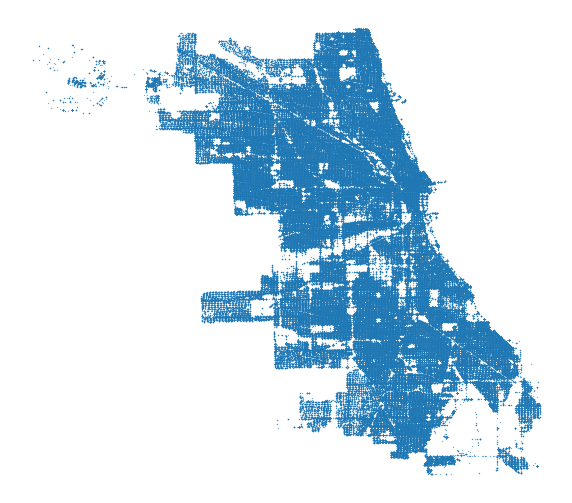

In [15]:
plt.figure(figsize=(10, 9))
plt.plot(*zip(*(df[["lon", "lat"]].values)), linestyle="", marker=".", markersize=0.5)
plt.gca().axis('off');

That looks legit.

## Using `geopandas` to create a grid

`geopandas` will help us a lot today! First, we need to create a `GeoDataFrame` using our `DataFrame`: 

In [16]:
gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.lon, df.lat))

We could also include the Coordinate Reference System of the data set; we will skip this here (but the interested coder can take a look at the [documentation](https://geopandas.org/docs/reference/api/geopandas.GeoDataFrame.html)). 

Note that `geopandas.GeoDataFrame` converts the latitude/longitude coordinates into a `POINT` geometry:

In [17]:
gdf.head()

,time,crime,lat,lon,geometry
1,2020-03-17 21:30:00,THEFT,41.952052,-87.754660,POINT (-87.75466 41.95205)
3,2019-09-24 08:00:00,DECEPTIVE PRACTICE,41.852248,-87.623786,POINT (-87.62379 41.85225)
4,2019-10-13 20:30:00,THEFT,41.895732,-87.687784,POINT (-87.68778 41.89573)
8,2020-03-18 02:03:00,MOTOR VEHICLE THEFT,41.877110,-87.723990,POINT (-87.72399 41.87711)
9,2019-10-05 18:30:00,THEFT,41.882002,-87.662287,POINT (-87.66229 41.88200)


### Creating a grid

We want to create a grid in that all data points are included. Thus, we use the boundaries of our data to define the size of the grid.

In [18]:
lat_min, lat_max = df.lat.min(), df.lat.max()

lon_min, lon_max = df.lon.min(), df.lon.max()

In [19]:
lon_min, lat_min, lon_max, lat_max

(-87.939732936, 41.644589713, -87.524529378, 42.022671246)

Next, we should create the cells of this grid: 

In [20]:
side_size = 15  # number of cells 
cell_size = (lat_max-lat_min)/side_size

In [21]:
grid = []

In [22]:
for cell_x in np.arange(lon_min, lon_max, cell_size):
    for cell_y in np.arange(lat_min, lat_max, cell_size):
        cell = shapely.geometry.box(cell_x, cell_y, 
                                    cell_x + cell_size, 
                                    cell_y + cell_size)
        grid.append(cell)

In [23]:
gdf_grid = geopandas.GeoDataFrame(grid, columns=['geometry'])

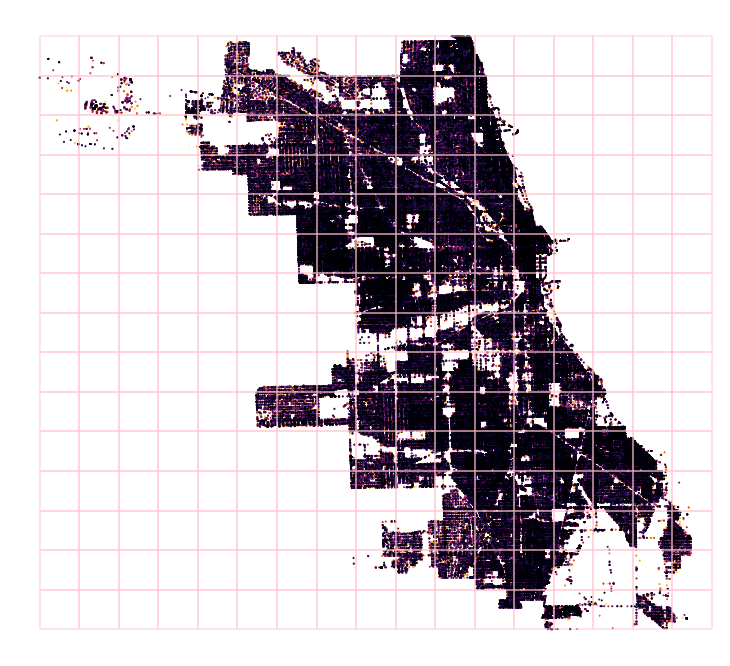

In [24]:
ax = gdf.plot(markersize=1, figsize=(15, 12), cmap='inferno_r')
plt.autoscale(False)
gdf_grid.plot(ax=ax, facecolor="none", edgecolor='pink', linewidth=2, alpha=0.4)
ax.axis("off");

### Counting the number of points in each cell

What we want now is to count the number of points in each cell. 

A quick way to do that is to just perfom a `join` [operation](https://en.wikipedia.org/wiki/Relational_algebra#Joins_and_join-like_operators)! 

With `geopandas`, this operation is trivial (for the interested reader: [documentation](https://geopandas.org/docs/reference/api/geopandas.sjoin.html)):

In [25]:
gdf_joined = geopandas.sjoin(gdf, gdf_grid, how='left', op='within')

In [26]:
gdf_joined.head()

,time,crime,lat,lon,geometry,index_right
1,2020-03-17 21:30:00,THEFT,41.952052,-87.754660,POINT (-87.75466 41.95205),117.0
3,2019-09-24 08:00:00,DECEPTIVE PRACTICE,41.852248,-87.623786,POINT (-87.62379 41.85225),188.0
4,2019-10-13 20:30:00,THEFT,41.895732,-87.687784,POINT (-87.68778 41.89573),144.0
8,2020-03-18 02:03:00,MOTOR VEHICLE THEFT,41.877110,-87.723990,POINT (-87.72399 41.87711),129.0
9,2019-10-05 18:30:00,THEFT,41.882002,-87.662287,POINT (-87.66229 41.88200),174.0



<div class="alert alert-info">
WHAT DOES THIS MEAN?
<img width=300 src=https://www.meme-arsenal.com/memes/9842c3db6d1639e09dbe3d55466d76fe.jpg>

</div>

To count, we dissolve (i.e., we `groupby` then aggregate our the groups via an aggregate function).

In [27]:
dissolve = gdf_joined.dissolve(by="index_right", aggfunc="count")

In [28]:
dissolve["crime"]

index_right
12.0        49
13.0        28
14.0        10
27.0       296
28.0      3531
         ...  
229.0    10846
240.0      319
241.0      446
242.0     2042
243.0       65
Name: crime, Length: 138, dtype: int64

In [29]:
gdf_grid.loc[dissolve.index, 'count'] = dissolve['crime'].values

In [30]:
gdf_grid

,geometry,count
0,"POLYGON ((-87.91453 41.64459, -87.91453 41.669...",NaN
1,"POLYGON ((-87.91453 41.66980, -87.91453 41.695...",NaN
2,"POLYGON ((-87.91453 41.69500, -87.91453 41.720...",NaN
3,"POLYGON ((-87.91453 41.72021, -87.91453 41.745...",NaN
4,"POLYGON ((-87.91453 41.74541, -87.91453 41.770...",NaN
...,...,...
250,"POLYGON ((-87.51124 41.89664, -87.51124 41.921...",NaN
251,"POLYGON ((-87.51124 41.92185, -87.51124 41.947...",NaN
252,"POLYGON ((-87.51124 41.94705, -87.51124 41.972...",NaN
253,"POLYGON ((-87.51124 41.97226, -87.51124 41.997...",NaN


<div class="alert alert-info">
WHY SO MANY NaNs? 
<img width=300 src=https://www.meme-arsenal.com/memes/9842c3db6d1639e09dbe3d55466d76fe.jpg>

</div>

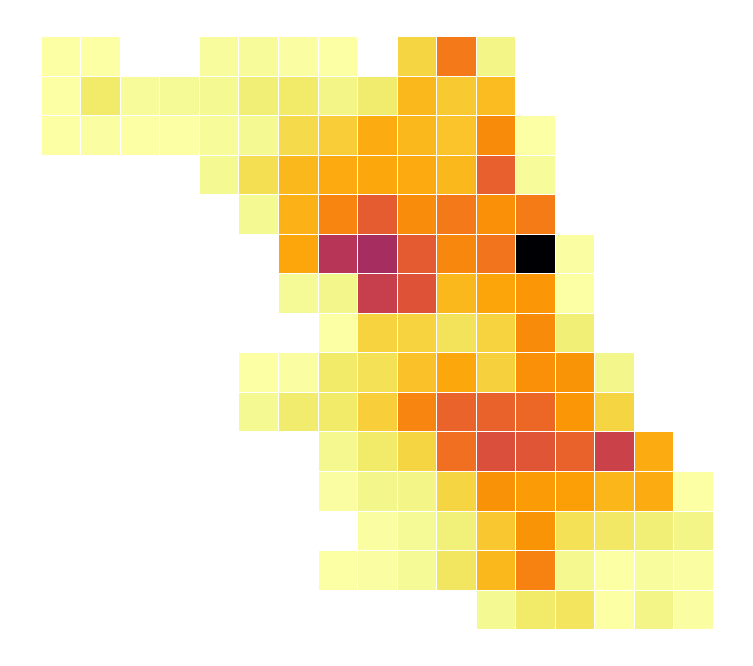

In [31]:
gdf_grid.plot(column='count', figsize=(15, 12), cmap='inferno_r', edgecolor="white")
plt.autoscale(False)
plt.gca().axis('off');

# Exercise

<div class="alert alert-success">
    <b>1)</b> Plot the Lorenz curves of crime for different types of crime.
</div>

Hint: The function `cumsum` from `numpy` will help you to calcualte the cumulative sum of a list.

<div class="alert alert-success">
    <b>1.b)</b> What is the impact of grid size on the Lorenz curves?
</div>

<div class="alert alert-success">
    <b>2)</b> Plot a time series of crime in a specific region.
</div>

Hint: Note that you can conveniently use the `groupby` function on the `gdf_joined` object (but you might be an extra variable).